<div align="center"> 

---

# **Alcohol consumption pattern**

</div>

----

<div align="center"> 

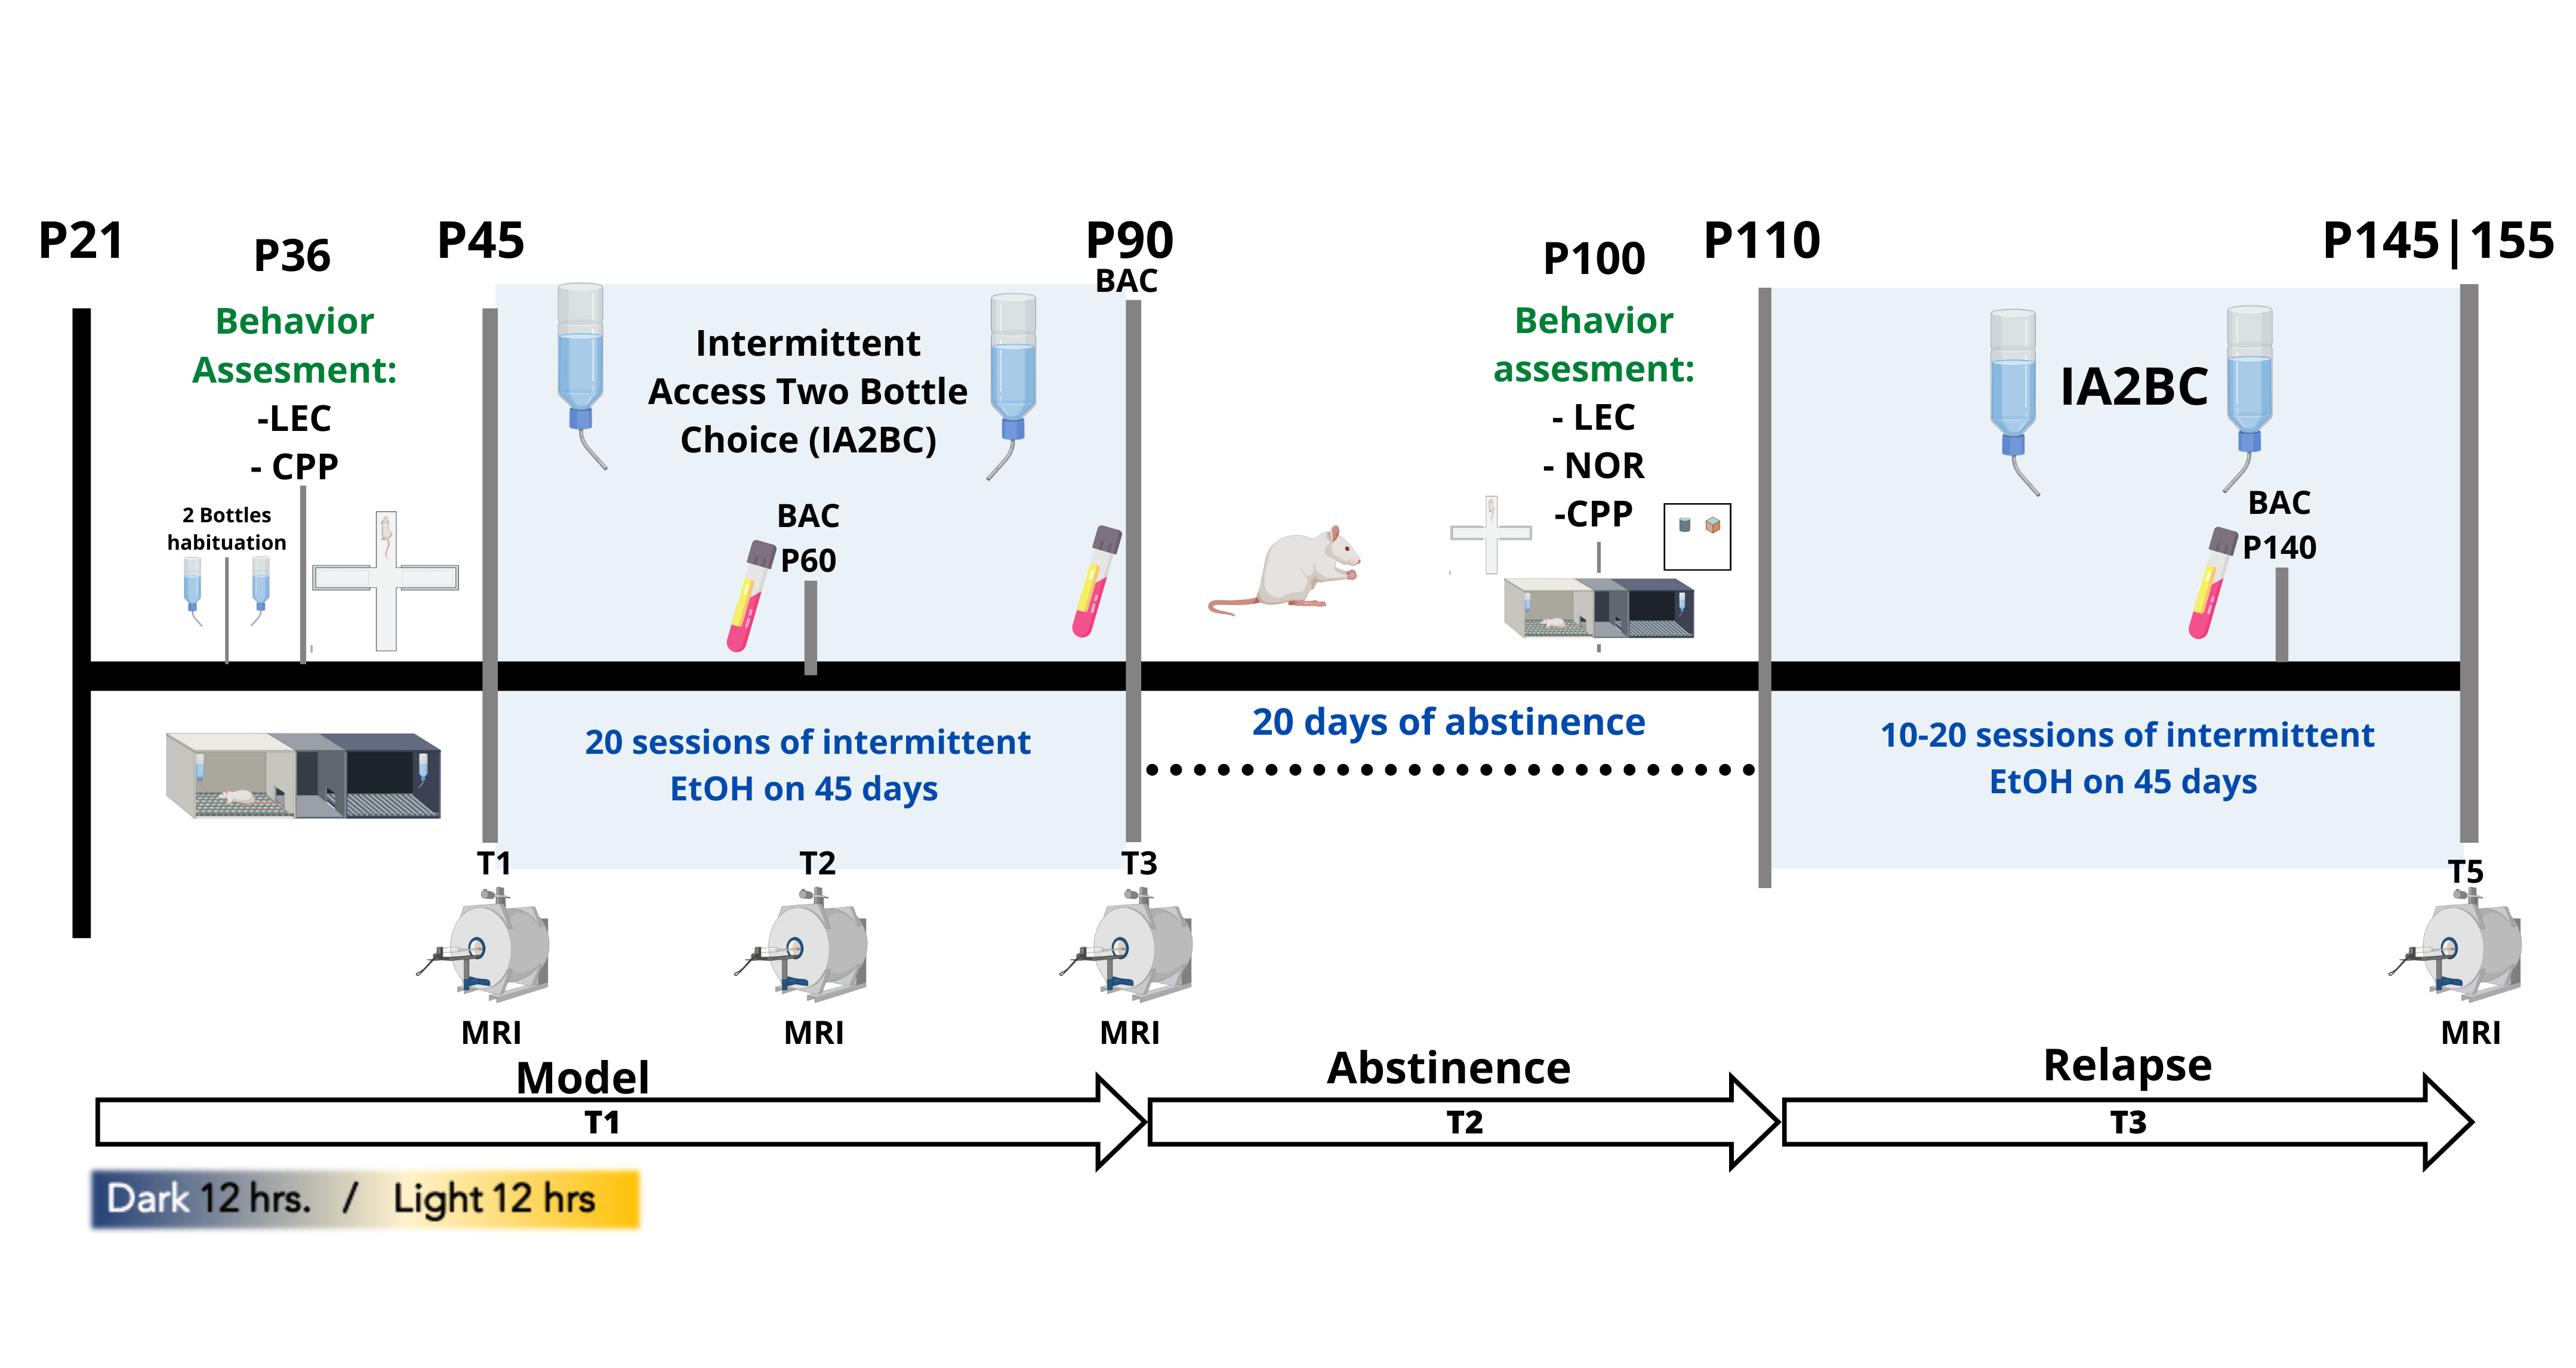

</div>

---
# <u> **Description:**</u>

Alcohol consumption of the rats of the six batches over the four months of the protocol.

---

## **Workflow**

1. Downloading files from drive
2. Data preparation
3. Analyses
4. Exploratory data
5. Visualization

---

**Variables to consider:** 
  - Session
  - Sex  
  
**Metrics**
  - Consumption pattern
  - Alcohol deprivation effect (ADE)
  
**Analysis:**
  - Latent class analysis 

---

### **General settings options**

In [1]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=12, repr.plot.height=8) # to resize plots

2 
2

## **1. Downloading files from drive**

### **1.1 Autenticate with your google drive credentials** 

Download datasets of the consumption. Run the next two cells and make sure of granting permisions to view, access, and modify google drive files (mark all the tick boxes).

---

In [ ]:
library(googledrive)
library(R.utils)
library(httr)

my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)


In [ ]:
 drive_auth(use_oob = TRUE, cache = F)

### **1.2 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [ ]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,devtools,ggpubr,ggthemes,SmartEDA,lme4,performance,rstatix,data.table,hablar,cowplot,lcmm,plotrix,finalfit,report,broom)


### **1.3 Download files**

Download files from google drive on the following link: 
https://drive.google.com/drive/folders/1D8n_B9wrqthQU2wfoK6iJdbjUXzdUryF

The downloaded files are: 

- datasets 1:6
---

In [4]:
setwd("/home/jalil/Documents/Psilantro/Sudmex_alcohol/coding/Sudmex-alcohol-rat")

In [ ]:
# |"""""""""""""""""""""""""""""""""""""""|
# |""" Datasets of alcohol consumṕtion """|
# |"""""""""""""""""""""""""""""""""""""""|

dir.create(path = paste0(getwd(),"/Data/Datasets"),recursive = T)

# Finding datasets
datasets_path <- "https://drive.google.com/drive/folders/1D8n_B9wrqthQU2wfoK6iJdbjUXzdUryF"
folder_id <- drive_get(as_id(datasets_path))
files <- drive_ls(folder_id)

setwd(paste0(getwd(),"/Data/Datasets"))
suppressMessages(invisible(capture.output(
seq(1:length(files$name)) %>% map(~ drive_download(file = files$id[.x],overwrite = T))
    )))
setwd(paste0(getwd(),"/../.."))


## **2. Data preparation**

Reading files and set it all up for Alcohol group

In [4]:
suppressMessages(
dataset_alcohol <- list.files(path = paste0(getwd(),"/Data/Datasets"), full.names = T) %>% map(~ .x %>% read_csv()) %>% plyr::rbind.fill() %>% 
  convert(chr(Sex,Session,Phase), num(Age,Weight_kg,EtOH,H2O)) %>%
  filter(Condition_day == "EtOH", Group == "Alc") %>% 
  select(RID,Sex,Session,Age,Weight_kg,Group,Condition,EtOH,H2O,Phase,Batch) %>%
  pivot_longer(cols=c(EtOH, H2O), values_to = "value", names_to = "Bottle") %>%
  pivot_wider(names_from = "Condition",values_from = "value") %>% 
  group_by(Bottle) 
    )

In [5]:
### Important issue: What point to set the NA threshold, that is, how much do the rats drank at 24 hrs ###

Alcohol_thresh <- dataset_alcohol %>% mutate(`24_hrs` = case_when(`24_hrs` >=60 ~ `24_hrs`))

General_intake <- Alcohol_thresh %>% 
  mutate(start_30mins = start - `30_mins`, 
         start_24_hrs = start - `24_hrs`,
         main_intake = (start_24_hrs * Weight_kg),
         basal_start = start - 27, 
         basal_30min = `30_mins` - 27,
         Basal_24hrs = `24_hrs` - 27,
         T_30min = basal_start - basal_30min,
         T_24hrs = basal_start - Basal_24hrs,
         Total_fluid_intake_24 = (T_24hrs * 100)/98.0608,
         Total_fluid_intake_30 = (T_30min * 100)/98.0608,
         Binge = (start_30mins* Weight_kg),
         Preferency = main_intake/Total_fluid_intake_24) 


Alcohol_intake <- General_intake %>% 
  filter(Bottle == "EtOH") %>%
  mutate(Sex = factor(Sex),
         Phase = factor(Phase)) %>% 
  ungroup

In [ ]:
AI_extremes <- Alcohol_intake %>% group_by(Group,Session) %>% identify_outliers(main_intake) %>% filter(is.extreme == TRUE) 
AI_extremes_NA <- AI_extremes %>% mutate(main_intake = case_when(main_intake <=15 ~ main_intake )) %>% select(-c(is.outlier,is.extreme))

Alcohol_intake <- Alcohol_intake %>% anti_join(AI_extremes) %>% bind_rows(AI_extremes_NA) 
AI_extremesB <- Alcohol_intake %>% group_by(Group,Session) %>% identify_outliers(Binge) %>% filter(is.extreme == TRUE) 
AI_extremesB_NA <- AI_extremesB %>% mutate(Binge = case_when(Binge <= 6 ~ Binge)) %>% 
                   select(-c(is.outlier,is.extreme))

#Alcohol_intake <- Alcohol_intake %>% anti_join(AI_extremesB) %>% bind_rows(AI_extremesB_NA) 

## **3. Analysis**

1. Consumption pattern
    - Latent class analysis
2. Alcohol deprivation effect

### **3.1 Consumption pattern**

#### **3.1.1 Latent class analysis**

In [6]:
Alcohol_model <- Alcohol_intake %>% select(RID,Weight_kg,Sex,main_intake,Age,Group,Session,Batch) 

invisible(capture.output(
lcmm_alcohol <- lcmm(main_intake ~ I(Age-45) + Sex,
                  random = ~ Batch, 
                  subject='RID', 
                  ng=1,
                  link = "linear",
                  data= Alcohol_model)
    
    ))

In [ ]:
lcmm_alcohol_2c <- gridsearch(rep = 30, maxiter = 100, minit = lcmm_alcohol,
                              lcmm(main_intake ~ I(Age-45) + Sex,  
                                   random = ~ Batch, 
                                   mixture = ~I(Age-45), 
                                   subject="RID", 
                                   data=Alcohol_model, 
                                   maxiter=200, 
                                   link = "linear",
                                   ng=2)) 


In [8]:
# probability of membership into class 1 or 2
prob_model = postprob(lcmm_alcohol_2c)

 
Posterior classification: 
  class1 class2
N  20.00  43.00
%  31.75  68.25
 
Posterior classification table: 
     --> mean of posterior probabilities in each class 
        prob1  prob2
class1 0.7391 0.2609
class2 0.1385 0.8615
 
Posterior probabilities above a threshold (%): 
         class1 class2
prob>0.7     50  76.74
prob>0.8     40  65.12
prob>0.9     25  58.14
 


In [9]:
Alcohol_classd <- full_join(Alcohol_intake, as.data.frame(lcmm_alcohol_2c$pprob[,1:2]), by ="RID") %>% convert(chr(Session)) %>% 
                      mutate(class=factor(class)) %>%
                  mutate(class = case_when(class == 1 ~ ifelse(prob_model[[1]][1] < prob_model[[1]][2],"High","Low"), 
                                           class == 2 ~ ifelse(prob_model[[1]][2] < prob_model[[1]][1],"High","Low"))) %>% 
                  mutate(RID = case_when(RID < 10 ~ paste0("sub-00", RID),
                                         RID < 100 ~ paste0("sub-0", RID),
                                         TRUE ~ paste0("sub-",RID)))

### **3.2 Alcohol deprivation effect**

Taken into account the first 3 sessions of alcohol-water 

In [10]:
ADE <- General_intake %>%
  select(RID,Phase,Bottle,main_intake,Session) %>% 
  filter(Phase == "Relapse") %>% na.omit %>%
  pivot_wider(names_from = "Bottle",values_from = "main_intake") %>% 
  mutate(Total_fluid = EtOH + H2O,
          ADE = EtOH / Total_fluid) %>% 
  filter(Session %in% c(1:3)) %>% 
  full_join(as.data.frame(lcmm_alcohol_2c$pprob[,1:2]), by ="RID") %>% convert(chr(Session)) %>% na.omit %>%
  mutate(class=factor(class)) %>% mutate(class = case_when(class == 1 ~ ifelse(prob_model[[1]][1] < prob_model[[1]][2],"High","Low"), 
                                                           class == 2 ~ ifelse(prob_model[[1]][2] < prob_model[[1]][1],"High","Low")))

### **3.3 Blood ethanol concentration**

In [ ]:
BEC <- read_csv("Data/BEC/BEC.csv")

## **4. Exploratory data**

In [6]:
ExpNumStat(Alcohol_classd,by="A",MesofShape=1,Outlier=TRUE,round=2)
# Low percentage of missing data and outliers

,Vname,Group,TN,nNeg,nZero,nPos,NegInf,PosInf,NA_Value,Per_of_Missing,⋯,min,max,mean,median,SD,CV,IQR,LB.25%,UB.75%,nOutliers
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,24_hrs,All,1596,0,0,1556,0,0,40,2.51,⋯,61.00,128.00,112.89,114.00,6.80,0.06,7.00,99.50,127.50,68
4,30_mins,All,1596,0,0,1566,0,0,30,1.88,⋯,97.00,128.00,119.08,119.00,2.69,0.02,2.00,115.00,123.00,82
1,Age,All,1596,0,0,1596,0,0,0,0.00,⋯,45.00,144.00,81.53,75.00,27.11,0.33,50.00,-15.00,185.00,0
11,Basal_24hrs,All,1596,0,0,1556,0,0,40,2.51,⋯,34.00,101.00,85.89,87.00,6.80,0.08,7.00,72.50,100.50,68
10,basal_30min,All,1596,0,0,1566,0,0,30,1.88,⋯,70.00,101.00,92.08,92.00,2.69,0.03,2.00,88.00,96.00,82
9,basal_start,All,1596,0,0,1566,0,0,30,1.88,⋯,72.00,102.00,93.19,93.00,2.33,0.03,2.00,89.00,97.00,59
16,Binge,All,1596,0,632,934,0,0,30,1.88,⋯,0.00,10.74,0.34,0.24,0.56,1.64,0.47,-0.71,1.18,77
8,main_intake,All,1596,1,20,1505,0,0,70,4.39,⋯,-0.26,19.78,2.19,1.62,2.13,0.97,2.11,-2.41,6.02,78
17,Preferency,All,1596,0,0,1506,0,0,90,5.64,⋯,0.07,0.57,0.29,0.27,0.09,0.33,0.13,0.03,0.54,11


In [13]:
Alcohol_classd %>% filter(Phase == "Model") %>% summary_factorlist("class",c("main_intake","Weight_kg","Age"), p = TRUE)

label,levels,High,Low,p
<chr>,<chr>,<chr>,<chr>,<chr>
main_intake,Mean (SD),2.8 (2.6),1.6 (1.5),<0.001
Weight_kg,Mean (SD),0.3 (0.1),0.3 (0.1),<0.001
Age,Mean (SD),66.9 (13.4),67.2 (13.4),0.702


In [8]:
Alcohol_classd %>% filter(Phase == "Model", Sex == "male") %>% summary_factorlist("class",c("main_intake","Weight_kg","Age"), p = TRUE)

label,levels,High,Low,p
<chr>,<chr>,<chr>,<chr>,<chr>
main_intake,Mean (SD),3.2 (2.8),1.9 (1.8),<0.001
Weight_kg,Mean (SD),0.3 (0.1),0.3 (0.1),0.050
Age,Mean (SD),66.4 (13.4),67.7 (13.4),0.259


In [9]:
Alcohol_classd %>% filter(Phase == "Model", Sex == "female") %>% summary_factorlist("class",c("main_intake","Weight_kg","Age"), p = TRUE)

label,levels,High,Low,p
<chr>,<chr>,<chr>,<chr>,<chr>
main_intake,Mean (SD),1.8 (1.6),1.4 (1.2),0.002
Weight_kg,Mean (SD),0.2 (0.0),0.2 (0.0),0.014
Age,Mean (SD),68.3 (13.4),67.0 (13.4),0.374


In [10]:
Alcohol_classd %>% filter(Phase == "Relapse") %>% summary_factorlist("class",c("main_intake","Weight_kg","Age"), p = TRUE)

label,levels,High,Low,p
<chr>,<chr>,<chr>,<chr>,<chr>
main_intake,Mean (SD),4.5 (2.5),2.3 (2.0),<0.001
Weight_kg,Mean (SD),0.4 (0.1),0.4 (0.1),<0.001
Age,Mean (SD),123.3 (9.4),121.0 (8.7),0.012


In [11]:
Alcohol_classd %>% filter(Phase == "Relapse", Sex == "male") %>% summary_factorlist("class",c("main_intake","Weight_kg","Age"), p = TRUE)

label,levels,High,Low,p
<chr>,<chr>,<chr>,<chr>,<chr>
main_intake,Mean (SD),4.9 (2.7),2.8 (2.5),<0.001
Weight_kg,Mean (SD),0.5 (0.1),0.5 (0.0),0.483
Age,Mean (SD),123.6 (9.5),119.7 (7.8),0.001


In [12]:
Alcohol_classd %>% filter(Phase == "Relapse", Sex == "female") %>% summary_factorlist("class",c("main_intake","Weight_kg","Age"), p = TRUE)

label,levels,High,Low,p
<chr>,<chr>,<chr>,<chr>,<chr>
main_intake,Mean (SD),3.8 (2.2),2.1 (1.6),<0.001
Weight_kg,Mean (SD),0.3 (0.0),0.3 (0.0),0.203
Age,Mean (SD),122.1 (9.1),121.9 (9.1),0.888


In [5]:
load("Data/Alcohol_consumption.RData")

In [ ]:
dataset <- list.files(path = paste0(getwd(),"/Data/Datasets"), full.names = T) %>% map(~ .x %>% read_csv()) %>% plyr::rbind.fill() %>% 
  convert(chr(Sex,Session,Phase), num(Age,Weight_kg,EtOH,H2O)) %>%
  filter(Condition_day == "EtOH", Group == c("Alc","Ctrl")) %>% 
  select(RID,Sex,Session,Age,Weight_kg,Group,Condition,EtOH,H2O,Phase,Batch) %>%
  pivot_longer(cols=c(EtOH, H2O), values_to = "value", names_to = "Bottle") %>%
  pivot_wider(names_from = "Condition",values_from = "value") %>% 
  group_by(Bottle)  %>% ungroup %>% select(RID,Sex) %>% unique

In [19]:
dataset

RID,Sex
<dbl>,<chr>
1,female
7,female
9,male
13,male
14,male
15,male
17,female
19,female
25,male


## **5. Visualization**

In [36]:
## Settings color and theme

pal_group <- c(alpha("#000000",0.6),"#B22222","#217175")
pal_sex <- c(alpha("#83458E",1),alpha("#28799f",1))
pal_groupSex <- c("#737373","#202020","#4D1857","#184557")
theme_settings <- theme(text = element_text(size=20,family = "Times New Roman"),axis.text.x = element_text(size=18),legend.title=element_blank())

dir.create(path = paste0(getwd(),"/Figures/Consumption"),recursive = T)


### **5.1 Alcohol intake by sex**

#### 5.1.1 Main intake along the whole protocol

In [37]:
plot_mainIntake <- ggline(Alcohol_classd, x = "Session", y =  "main_intake", group = "Sex", point.size = 2,
       add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
       ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings

#### 5.1.2 Binge along the whole protocol

In [38]:
plot_binge <- ggline(Alcohol_classd, x = "Session", y =  "Binge", group = "Sex", point.size = 2,
       add = c("mean_se"), size=2, color = "Sex", facet.by = "Phase", palette = pal_sex,
       ylab = "Binge (g/kg/30 min)", xlab = "Sessions") + theme_settings

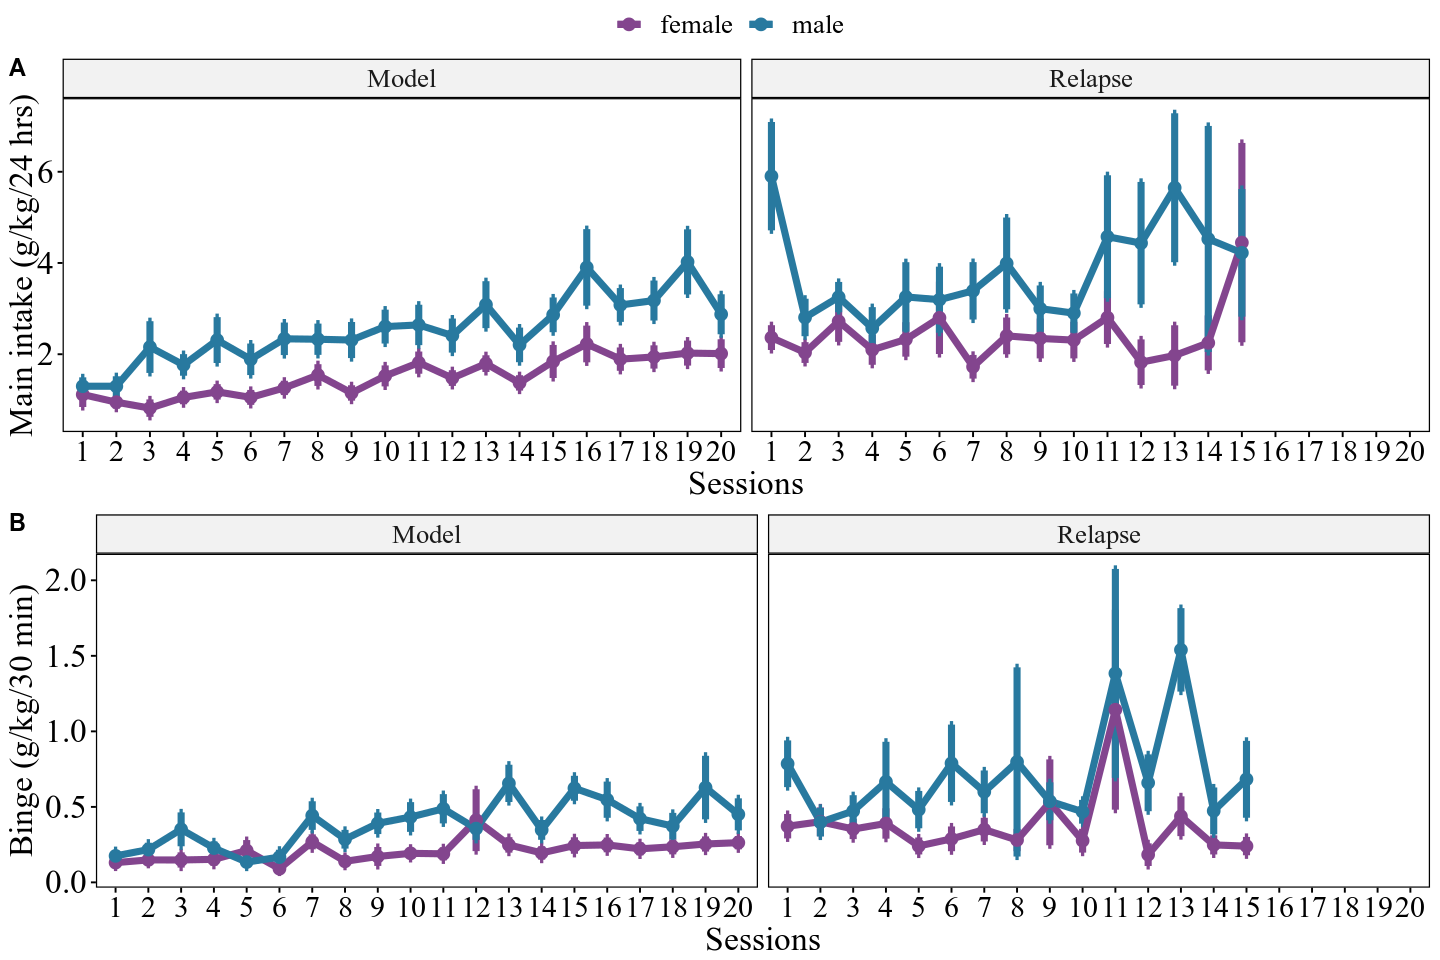

In [39]:
plot_consumption <-  ggarrange(plot_mainIntake, plot_binge, labels = c("A", "B"), ncol = 1, common.legend = T)
plot_consumption

### **5.2 Alcohol intake by consumption pattern**

#### 5.2.1 Main intake along the whole protocol

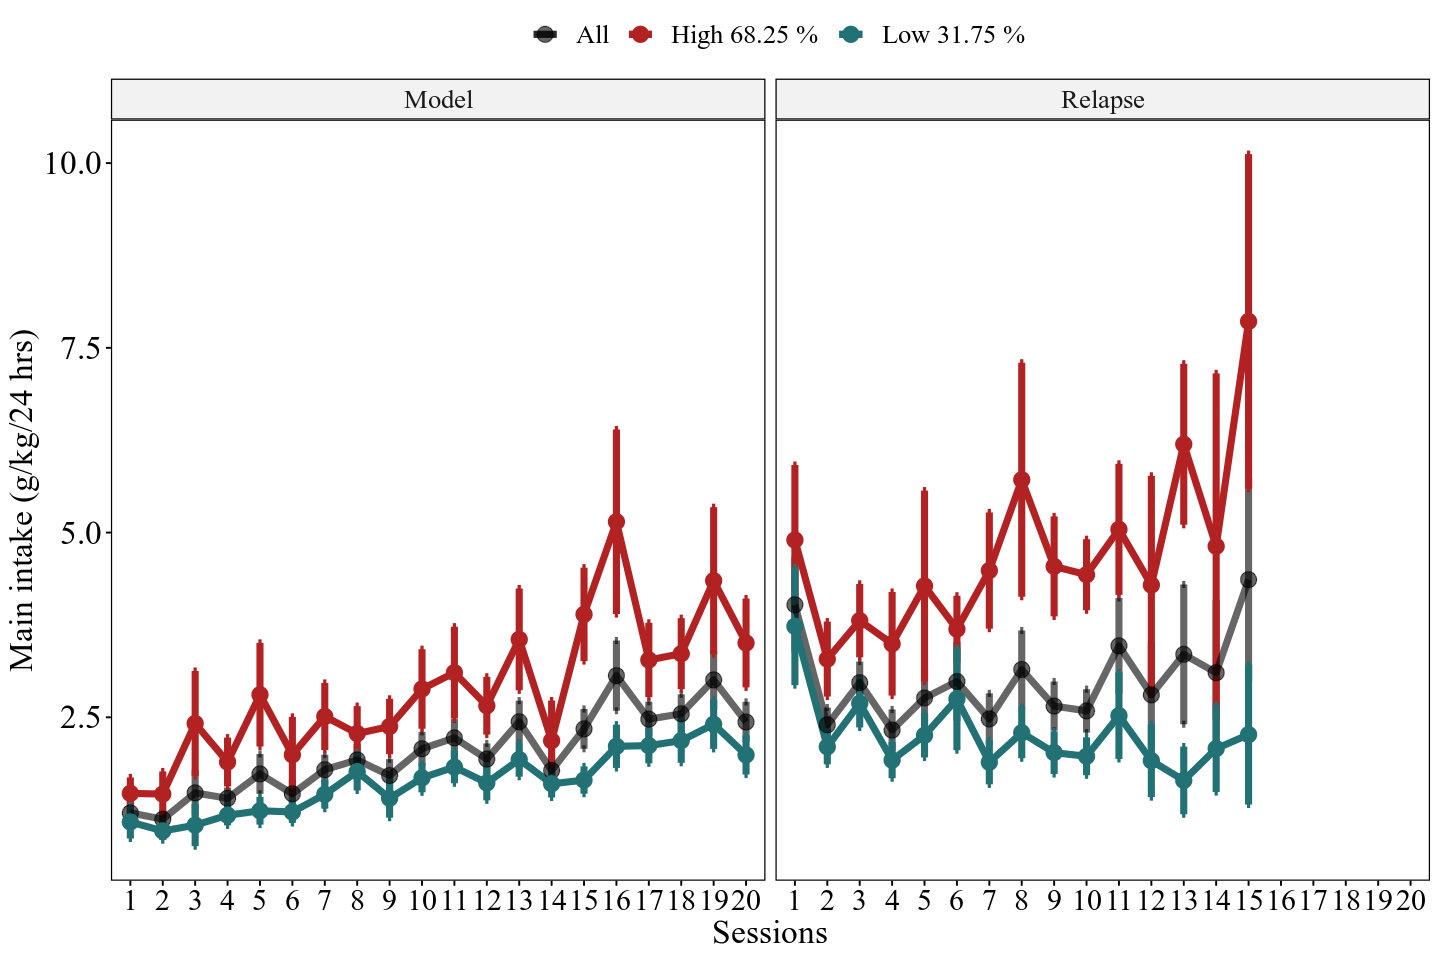

In [40]:
plot_class <- rbind.data.frame(Alcohol_classd,Alcohol_classd %>% 
    mutate(class = case_when(class == "Low" ~ "All", class == "High" ~ "All")) ) %>% 
    mutate(class = case_when(class == "High" ~ paste0("High ", prob_model[1][[1]][4]," %"), 
                             class == "Low" ~ paste0("Low ", prob_model[1][[1]][2], " %"), 
                             class == "All" ~ "All")) %>% 
    ggline(x = "Session", y =  "main_intake", group = "class", point.size = 3,
           add = c("mean_se"), size=2, color = "class", facet.by = "Phase", palette = pal_group,
           legend.title = "Group", 
           ylab = "Main intake (g/kg/24 hrs)", xlab = "Sessions") + theme_settings 
plot_class

#### 5.2.2 Binge along the whole protocol

In [41]:
plot_class_binge <- rbind.data.frame(Alcohol_classd,Alcohol_classd %>% mutate(class = case_when(class == "Low" ~ "All", class == "High" ~ "All")) ) %>% 
    mutate(class = case_when(class == "Low" ~ paste0("Low ", prob_model[1][[1]][4]," %"), 
                             class == "High" ~ paste0("High ", prob_model[1][[1]][2], " %"), 
                             class == "All" ~ "All")) %>% 
    ggline(x = "Session", y =  "Binge", group = "class", point.size = 3,
           add = c("mean_se"), size=2, color = "class", facet.by = "Phase", palette = pal_group,
           legend.title = "Group", 
           ylab = "Binge (g/kg/30 min)", xlab = "Sessions") + theme_settings

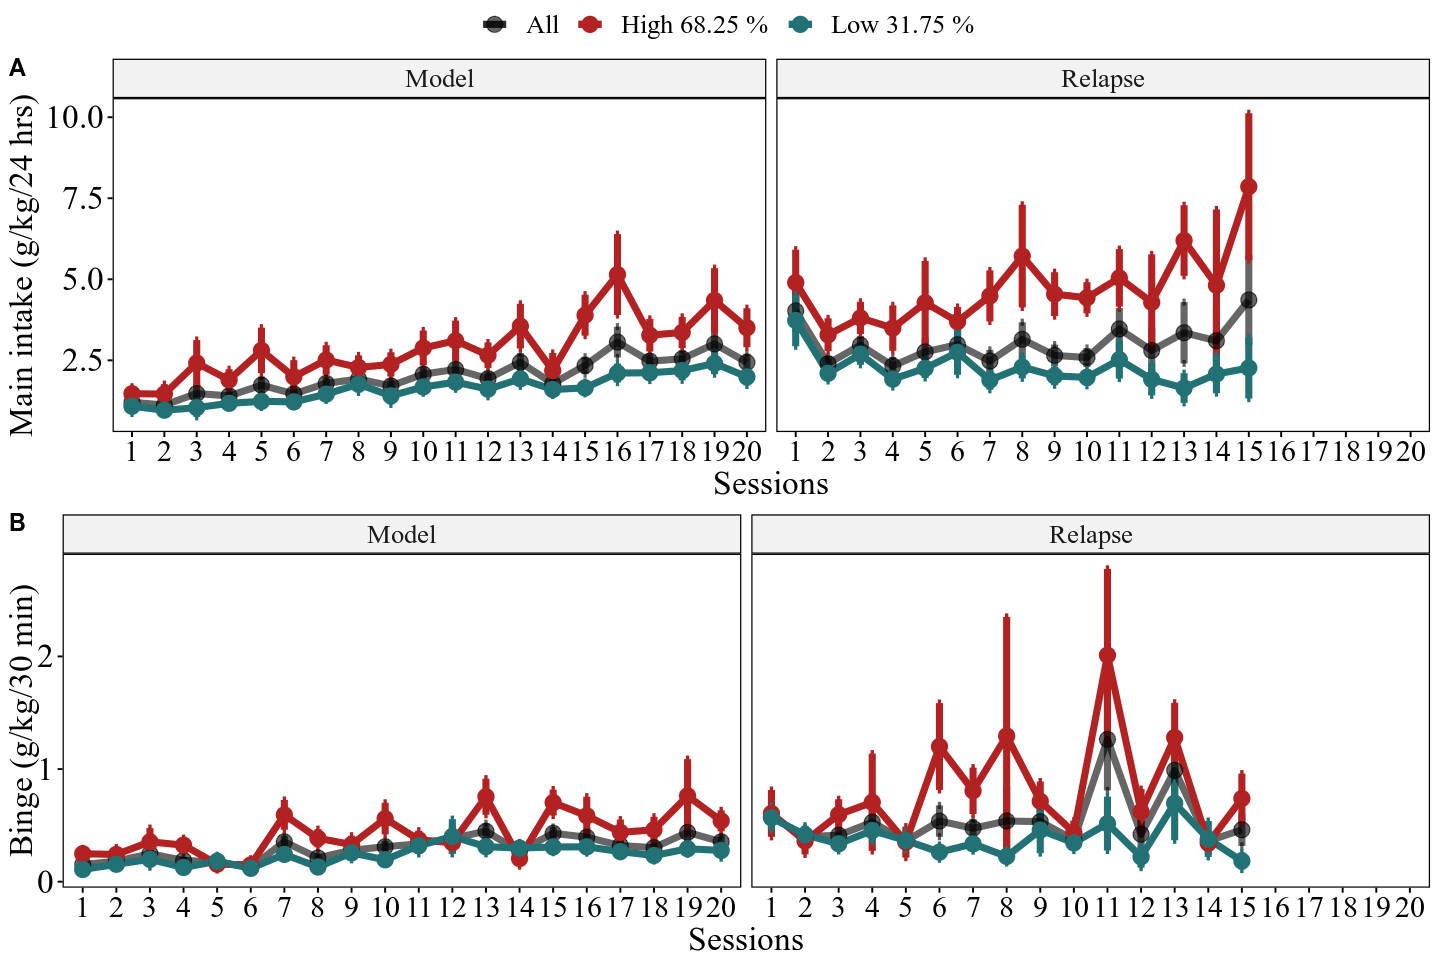

In [42]:
plot_clss_consumption <-  ggarrange(plot_class, plot_class_binge, labels = c("A", "B"), ncol = 1, common.legend = T)
plot_clss_consumption

#### **5.3 Alcohol deprivation effect**

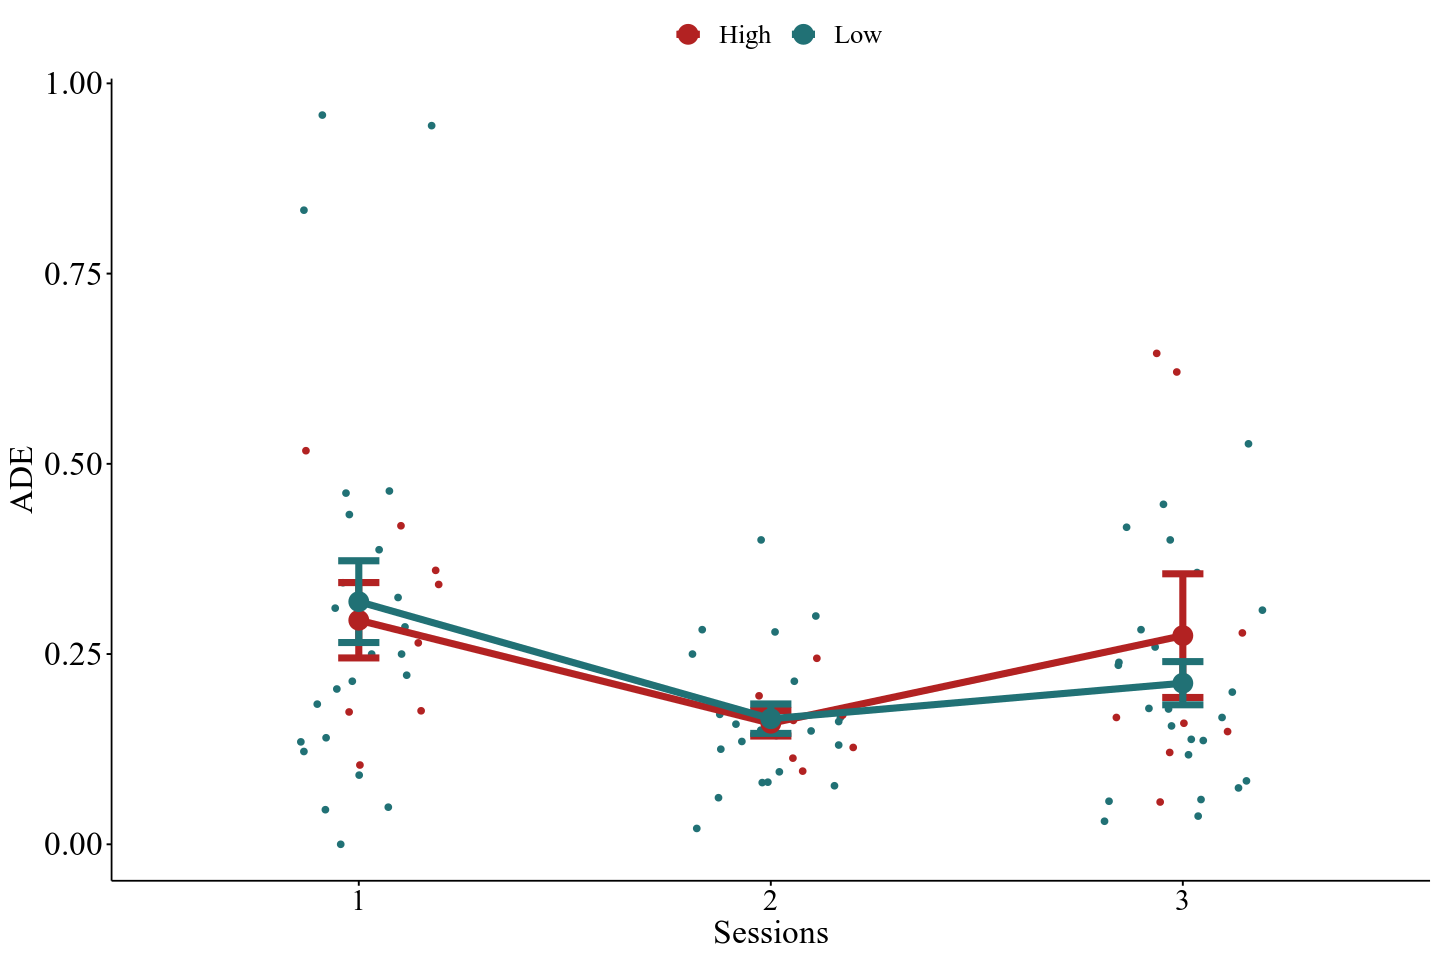

In [43]:
plot_ADE <- ggline(ADE, x = "Session", y =  "ADE", group = "class",
              add = c("mean_se", "jitter"), point.size = 4, 
              size=2, color = "class", palette = pal_group[2:3],
              xlab = "Sessions", ylab = "ADE") + theme_settings
plot_ADE

#### **5.3 Alcohol deprivation effect**

In [44]:
BEC_female <- ggscatter(BEC %>% filter(Sex == "Female"), x = "g/kg/240min", y = "BEC (ng/ul)",
 add = "reg.line", conf.int = TRUE, color = pal_sex[1], add.params = list(color = pal_sex[1], fill = "lightgray")) + theme_settings

In [45]:
BEC_male <- ggscatter(BEC %>% filter(Sex == "Male"), x = "g/kg/240min", y = "BEC (ng/ul)",
 add = "reg.line", conf.int = TRUE, color = pal_sex[2], add.params = list(color = pal_sex[2], fill = "lightgray")) + theme_settings

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



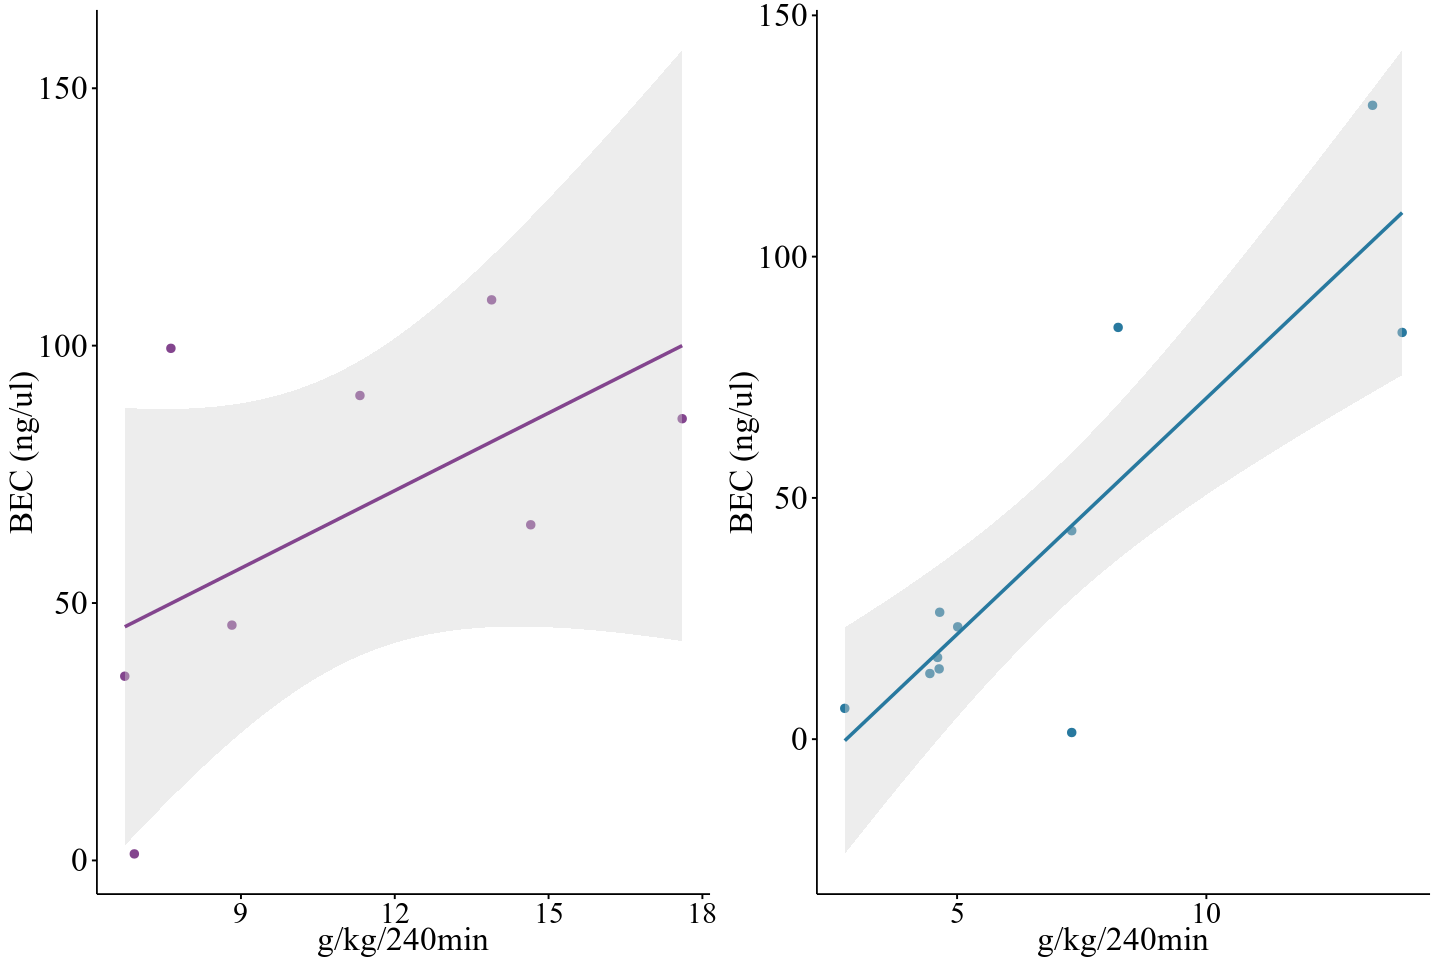

In [46]:
ggarrange(BEC_female,BEC_male)

#### **5.4 Preferency index**

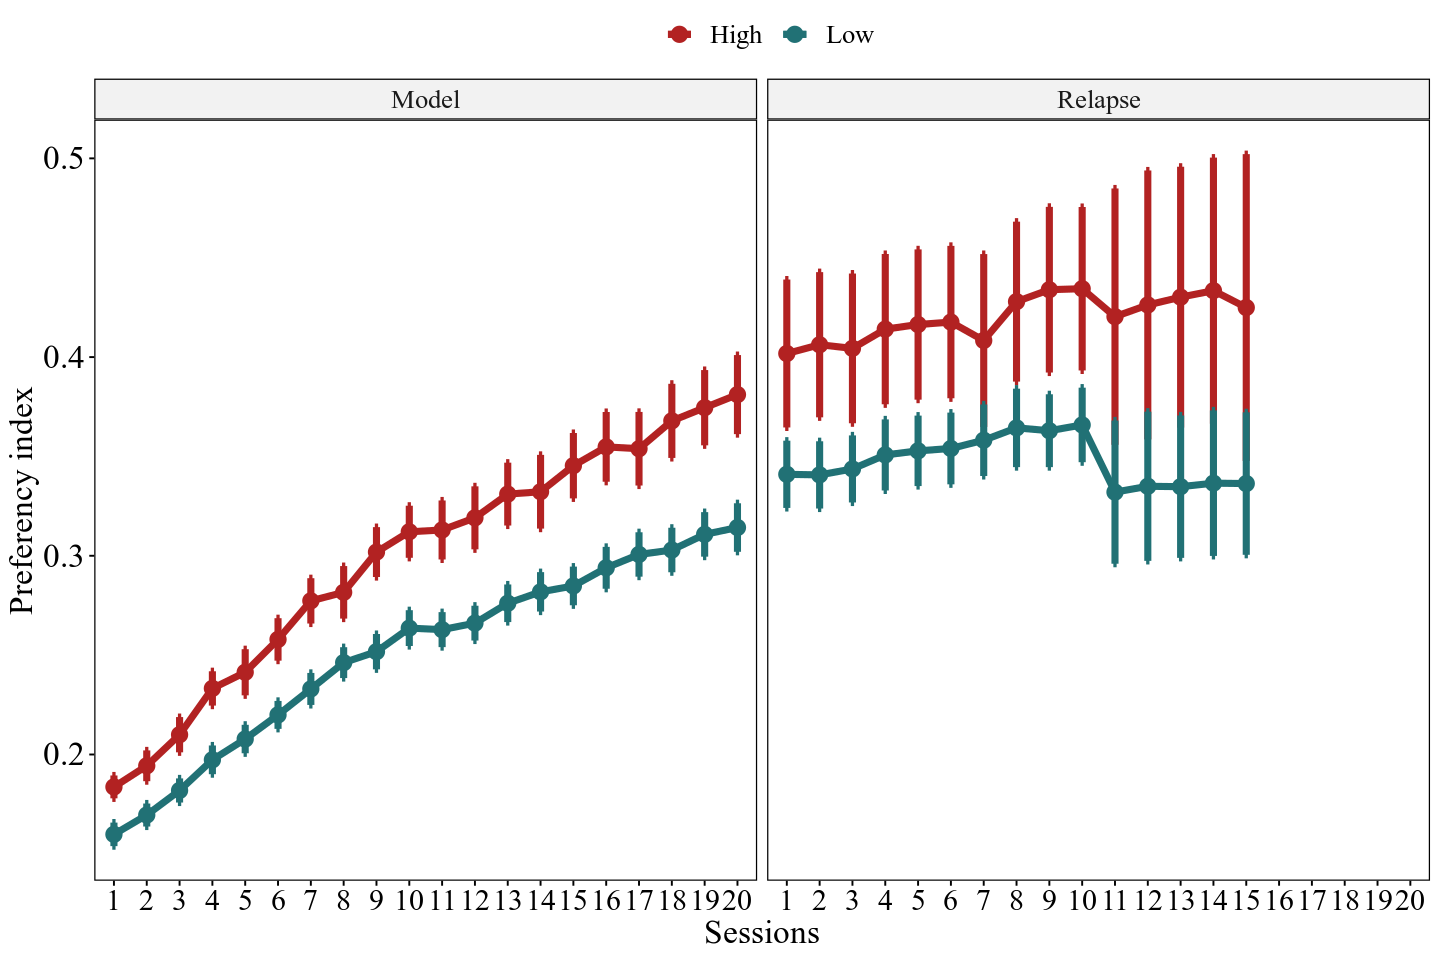

In [48]:
plot_class_preferency <- Alcohol_classd %>% ggline(x = "Session", y =  "Preferency", group = "class", point.size = 3,
           add = c("mean_se"), size=2, color = "class", facet.by = "Phase", palette = pal_group[2:3],
           legend.title = "Group", 
           ylab = "Preferency index", xlab = "Sessions") + theme_settings
plot_class_preferency

## **6. Export data**

In [49]:
ggsave(plot = plot_mainIntake, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/Consumption/Main_intake-sex.png")

ggsave(plot = plot_class_binge, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/Consumption/Binge-Classification.png")

ggsave(plot = plot_class, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/Consumption/Main_intake-classification.png")

In [50]:
ggsave(plot = plot_consumption, dpi=300,height = 12, width = 12,bg="white",
       filename = "Figures/Consumption/Main_intake-sex_AB.png")

ggsave(plot = plot_clss_consumption, dpi=300,height = 12, width = 12,bg="white",
       filename = "Figures/Consumption/Main_intake-classification_AB.png")

In [51]:
ggsave(plot = plot_class_preferency, dpi=300,height = 12, width = 12,bg="white",
       filename = "Figures/Consumption/Preferency_index.png")

In [52]:
Alcohol_classd %>% select(RID,class,Sex) %>% unique %>% write_csv("Data/Class.csv")

In [53]:
save(Alcohol_classd,General_intake,ADE,lcmm_alcohol_2c,BEC,prob_model,pal_group,pal_sex,theme_settings,
     file = paste0(getwd(),"/Data/Alcohol_consumption.RData"))